### Logistic Model for Binary Classification

A retail banking institution is going to float a stock trading facility for their existing customer. Since this kind of facitlity is nothing new , company knows that they will have to incetivise their customers for adopting their offerings. One way to incetiwise is to offer discounts on the commision for trading transactions.

One issue with that is that only about 10% of the customers do enought trades for earnings after discounts to be profitable. Company wants to figure out, which are those 10% customer so that it can selectively offer them discount. there is no magic way to figure that out. So company rolled out this service to about 10000+ of their customers and observed their trading behaviour for 6 months and after that they labelled them into two revenue.grids 1 and 2. using this data, now they want us to build a classification model which can be used to classify their remaining customers into these revenue grids.

#### Logistic Regression from Scikit Learn

Logistic Regression in scikit learn already contains penalties. l1 and l2 [Read as L-one & L-two] penalties . l1 penalty is same as lasso penalty where as l2 is same as ridge penalty. parameter C for logistic regression function is the hyperparameter for penalty . However it works in inverse fashion, i.e. if C takes smalle , it means higher penalty.

For the case that we have discussed here , we have discussed l1 penalty with value of C as 1. We have left following things for you to try on your own.

* model with l2 penalty
* Finding optimal value of hyperparameter C with cross-validation for both the penalties

You will find these in the practice exercise as well

you can use auc value obtained from function roc_auc_score to select best value for the hyperparameter. Higher the auc, better is the model . If you dont recall this, please go back to the theoretical reading material.

Lets beging our model building process.

In [2]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
data_file=r'Existing Base.csv'
bd=pd.read_csv(data_file)

In [3]:
bd.head()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,...,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,1,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,...,19.99,0.00,0.00,1,Female,Wales,74.67,18.66,32.32,89.43
1,2,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,...,0.00,0.00,0.00,2,Female,North West,20.19,0.00,4.33,22.78
2,3,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,...,0.00,3.49,0.00,2,Male,North,98.06,31.07,80.96,171.78
3,5,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,...,0.00,0.00,0.00,2,Female,West Midlands,4.10,14.15,17.57,-41.70
4,6,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,...,0.00,45.91,25.98,2,Female,Scotland,70.16,55.86,80.44,235.02


In [4]:
bd.dtypes

REF_NO                               int64
children                            object
age_band                            object
status                              object
occupation                          object
occupation_partner                  object
home_status                         object
family_income                       object
self_employed                       object
self_employed_partner               object
year_last_moved                      int64
TVarea                              object
post_code                           object
post_area                           object
Average Credit Card Transaction    float64
Balance Transfer                   float64
Term Deposit                       float64
Life Insurance                     float64
Medical Insurance                  float64
Average A/C Balance                float64
Personal Loan                      float64
Investment in Mutual Fund          float64
Investment Tax Saving Bond         float64
Home Loan  

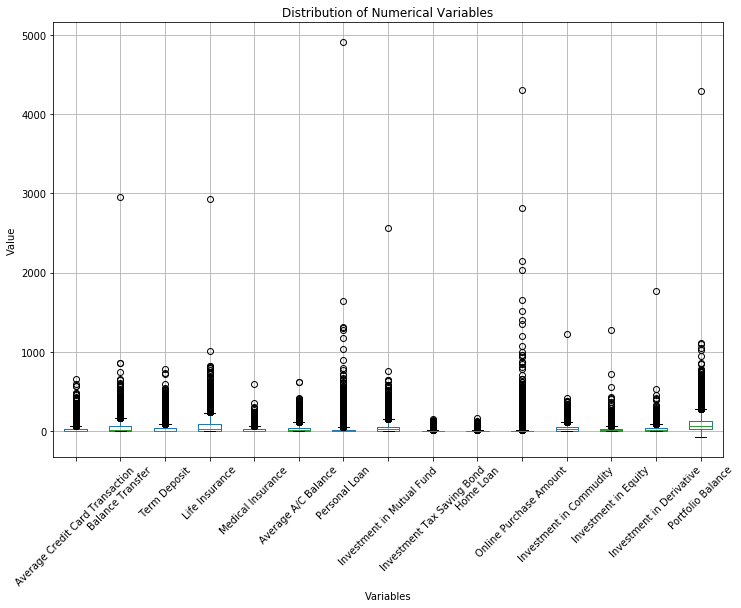

In [12]:
# Boxplot of numerical variables
numerical_vars = ['Average Credit Card Transaction', 'Balance Transfer', 'Term Deposit',
                  'Life Insurance', 'Medical Insurance', 'Average A/C Balance',
                  'Personal Loan', 'Investment in Mutual Fund', 'Investment Tax Saving Bond',
                  'Home Loan', 'Online Purchase Amount', 'Investment in Commudity',
                  'Investment in Equity', 'Investment in Derivative', 'Portfolio Balance']

plt.figure(figsize=(12, 8))
bd[numerical_vars].boxplot(rot=45)
plt.xlabel('Variables')
plt.ylabel('Value')
plt.title('Distribution of Numerical Variables')
plt.show()

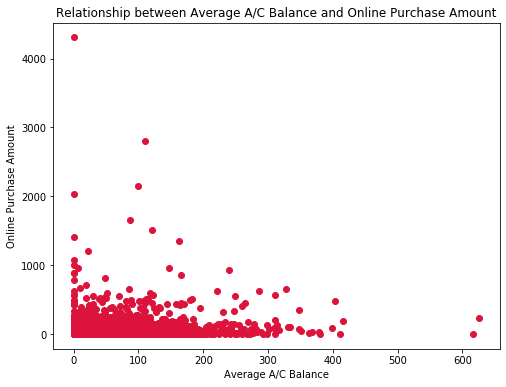

In [8]:
# Scatter plot of 'Average A/C Balance' vs 'Online Purchase Amount'
plt.figure(figsize=(8, 6))
plt.scatter(bd['Average A/C Balance'], bd['Online Purchase Amount'],color='crimson')
plt.xlabel('Average A/C Balance')
plt.ylabel('Online Purchase Amount')
plt.title('Relationship between Average A/C Balance and Online Purchase Amount')
plt.show()

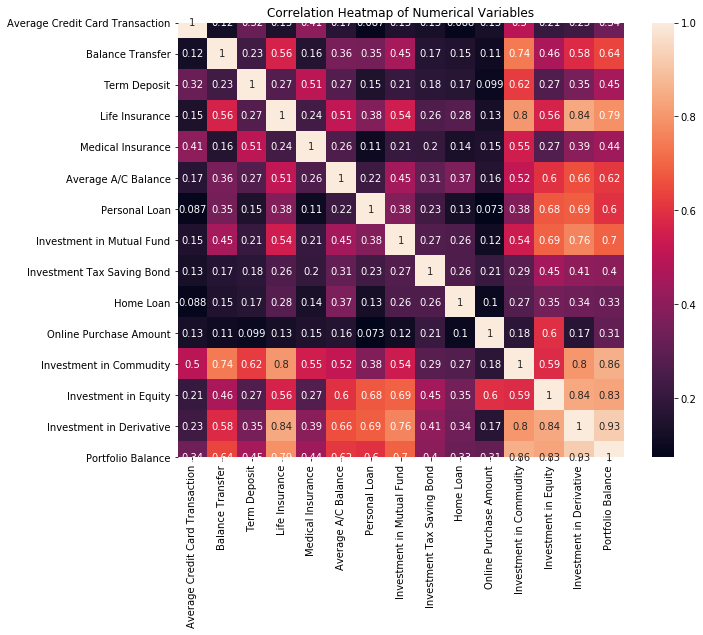

In [7]:
# Correlation heatmap of numerical variables
plt.figure(figsize=(10, 8))
sns.heatmap(bd[numerical_vars].corr(), annot=True, cmap='rocket')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

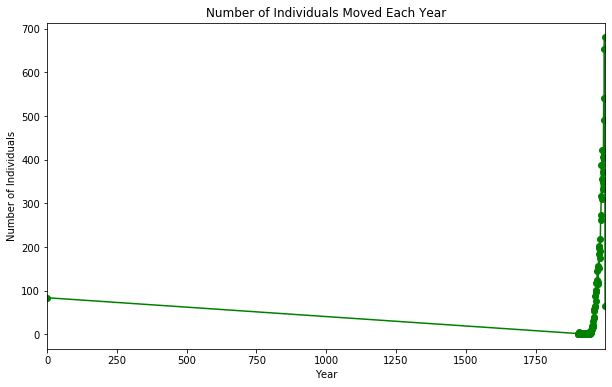

In [13]:
# Line plot of 'year_last_moved'
year_counts = bd['year_last_moved'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
year_counts.plot(kind='line', marker='o',color='g')
plt.xlabel('Year')
plt.ylabel('Number of Individuals')
plt.title('Number of Individuals Moved Each Year')
plt.show()

##### For Children

In [9]:
bd["children"].value_counts()

Zero    6208
1       1848
2       1607
3        473
4+        19
Name: children, dtype: int64

It seems we can directly convert this to numeric.

In [10]:
bd.loc[bd["children"]== "Zero","children"]="0"
bd.loc[bd["children"]== "4+","children"]="4"
bd["children"]=pd.to_numeric(bd["children"],errors="coerce")

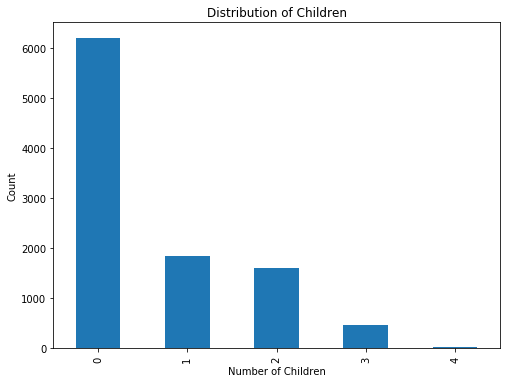

In [11]:
# Bar chart of 'children' value counts
plt.figure(figsize=(8, 6))
bd['children'].value_counts().plot(kind='bar')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.title('Distribution of Children')
plt.show()

##### For Revenue Grid

In [15]:
bd["y"]=np.where(bd["Revenue Grid"]==2,0,1)
bd=bd.drop(["Revenue Grid"],1)

##### For Age_Band

* For variable , age_band if we treat it as categorical variable , we can combine its categories by looking average response rate across its categories.

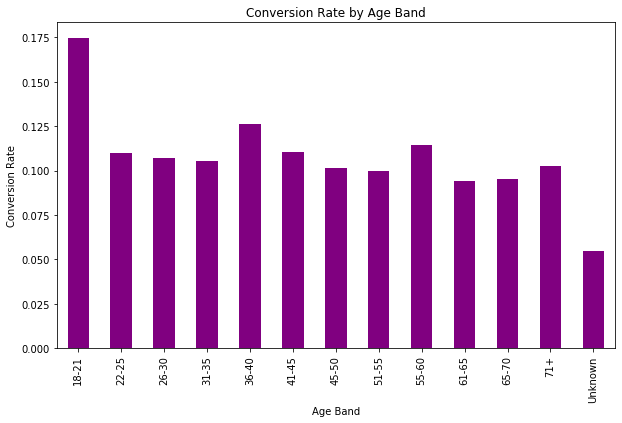

In [17]:
# Bar chart of 'age_band' mean conversion rate
plt.figure(figsize=(10, 6))
bd.groupby('age_band')['y'].mean().plot(kind='bar',color='purple')
plt.xlabel('Age Band')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Age Band')
plt.show()

In [14]:
round(bd.groupby("age_band")["y"].mean(),2)

age_band
18-21      0.17
22-25      0.11
26-30      0.11
31-35      0.11
36-40      0.13
41-45      0.11
45-50      0.10
51-55      0.10
55-60      0.11
61-65      0.09
65-70      0.10
71+        0.10
Unknown    0.05
Name: y, dtype: float64

In [15]:
for i in range(len(bd)):
    if bd["age_band"][i] in ["71+","65-70","51-55","45-50"]:
        bd.loc[i,"age_band"]="ab_10"
    if bd["age_band"][i] in ["55-60","41-45","31-35","22-25","26-30"]:
        bd.loc[i,"age_band"]="ab_11"
    if bd["age_band"][i] in ["36-40"]:
        bd.loc[i,"age_band"]="ab_13"
    if bd["age_band"][i] in ["18-21"]:
        bd.loc[i,"age_band"]="ab_17"
    if bd["age_band"][i] in ["61-65"]:
        bd.loc[i,"age_band"]="ab_9"
ab_dummies=pd.get_dummies(bd["age_band"])
ab_dummies.head()

,Unknown,ab_10,ab_11,ab_13,ab_17,ab_9
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,1,0,0,0,0


In [16]:
bd=pd.concat([bd,ab_dummies],1)
bd=bd.drop(["age_band","Unknown"],1)

##### For Status

In [17]:
bd["status"].value_counts()

Partner                 7709
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: status, dtype: int64

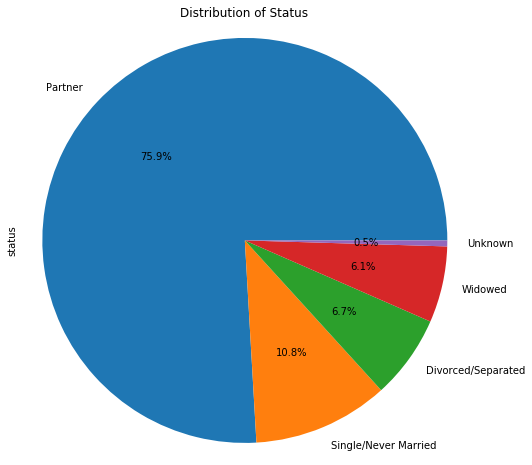

In [18]:
# Pie chart of 'status' value counts
plt.figure(figsize=(8, 8))
bd['status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Status')
plt.show()

In [19]:
bd["st_partner"]=np.where(bd["status"]=="Partner",1,0)
bd["st_singlenm"]=np.where(bd["status"]=="single/Never Married",1,0)
bd["st_divsep"]=np.where(bd["status"]=="Divorced/Separated",1,0)
bd=bd.drop(["status"],1)

##### For Occupation

<Figure size 720x432 with 0 Axes>

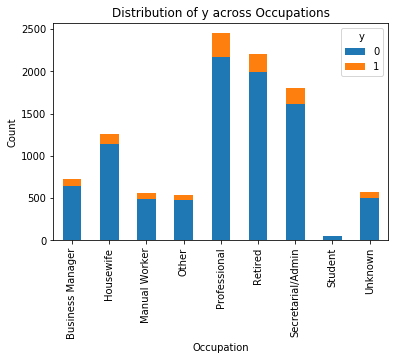

In [20]:
# Stacked bar chart of 'occupation' and 'y'
plt.figure(figsize=(10, 6))
occupation_y_counts = bd.groupby('occupation')['y'].value_counts().unstack()
occupation_y_counts.plot(kind='bar', stacked=True)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Distribution of y across Occupations')
plt.legend(title='y', loc='upper right')
plt.show()

In [21]:
round(bd.groupby("occupation")["y"].mean(),2)

occupation
Business Manager     0.12
Housewife            0.09
Manual Worker        0.11
Other                0.11
Professional         0.12
Retired              0.10
Secretarial/Admin    0.11
Student              0.11
Unknown              0.11
Name: y, dtype: float64

In [22]:
for i in range(len(bd)):
    if bd["occupation"][i] in ["Unknown","Student","Secretarial/Admin","Other","Manual Worker"]:
        bd.loc[i,"occupation"]="oc_11"
    if bd["occupation"][i] in ["Professional","Business Manager"]:
        bd.loc[i,"occupation"]="oc_12"
    if bd["occupation"][i] in ["Retired"]:
        bd.loc[i,"occupation"]="oc_10"
oc_dummies=pd.get_dummies(bd["occupation"])
oc_dummies.head()

,Housewife,oc_10,oc_11,oc_12
0,0,0,1,0
1,0,1,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [23]:
bd=pd.concat([bd,oc_dummies],1)
bd=bd.drop(["occupation","Housewife"],1)

##### For occupation partner

In [24]:
round(bd.groupby("occupation_partner")["y"].mean(),2)

occupation_partner
Business Manager     0.11
Housewife            0.11
Manual Worker        0.11
Other                0.10
Professional         0.11
Retired              0.10
Secretarial/Admin    0.12
Student              0.12
Unknown              0.10
Name: y, dtype: float64

In [25]:
bd["ocp_10"]=0
bd["ocp_12"]=0
for i in range(len(bd)):
    if bd["occupation_partner"][i] in ["Unknown","Retired","Other"]:
        bd.loc[i,"ocp_10"]=1
    if bd["occupation_partner"][i] in ["Student","Secretarial/Admin"]:
        bd.loc[i,"ocp_12"]=1
        
bd=bd.drop(["occupation_partner","TVarea","post_code","post_area","region"],1)

* You can see that we have also dropped variables TVarea, region, post_code, post_area. If you look at number of unique values taken by post_area and post_code , you'll realise why decided to drop them. TVarea and region on the other hand we have left for you to make use of and see if using them improves your model.

##### For home status

In [26]:
bd["home_status"].value_counts()

Own Home                9413
Rent from Council/HA     322
Rent Privately           261
Live in Parental Hom     109
Unclassified              50
Name: home_status, dtype: int64

In [27]:
bd["hs_own"]=np.where(bd["home_status"]=="Own Home",1,0)
del bd["home_status"]

* Notice that we used an alternate syntax for dropping a column here. You can use that too if you like this syntax better

##### For Gender

In [28]:
bd["gender"].value_counts()

Female     7634
Male       2486
Unknown      35
Name: gender, dtype: int64

In [29]:
bd["gender_f"]=np.where(bd["gender"]=="Female",1,0)
del bd["gender"]

##### For self employed

In [30]:
bd["self_employed"].value_counts()

No     9436
Yes     719
Name: self_employed, dtype: int64

In [31]:
bd["semp_yes"]=np.where(bd["self_employed"]=="Yes",1,0)
del bd["self_employed"]

##### For self employed partner

In [32]:
bd["self_employed_partner"].value_counts()

No     9026
Yes    1129
Name: self_employed_partner, dtype: int64

In [33]:
bd["semp_part_yes"]=np.where(bd["self_employed_partner"]=="Yes",1,0)
del bd["self_employed_partner"]

##### For family income

* We can convert this to number as average of the range once we have figured out what to do with category "Unknown".

In [34]:
bd["family_income"].value_counts()

>=35,000             2517
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: family_income, dtype: int64

In [18]:
round(bd.groupby("family_income")["y"].mean(),4)

family_income
< 4,000              0.0755
< 8,000, >= 4,000    0.0796
<10,000, >= 8,000    0.1066
<12,500, >=10,000    0.1019
<15,000, >=12,500    0.1113
<17,500, >=15,000    0.1230
<20,000, >=17,500    0.1113
<22,500, >=20,000    0.1186
<25,000, >=22,500    0.1032
<27,500, >=25,000    0.0970
<30,000, >=27,500    0.1157
>=35,000             0.1116
Unknown              0.0703
Name: y, dtype: float64

In [19]:
bd["fi"]=4 # by doing this , we have essentially clubbed <4000 and Unknown values . How?
bd.loc[bd["family_income"]=="< 8,000, >= 4,000","fi"]=6
bd.loc[bd["family_income"]=="<10,000, >= 8,000","fi"]=9
bd.loc[bd["family_income"]=="<12,500, >=10,000","fi"]=11.25
bd.loc[bd["family_income"]=="<15,000, >=12,500","fi"]=13.75
bd.loc[bd["family_income"]=="<17,500, >=15,000","fi"]=16.25
bd.loc[bd["family_income"]=="<20,000, >=17,500","fi"]=18.75
bd.loc[bd["family_income"]=="<22,500, >=20,000","fi"]=21.25
bd.loc[bd["family_income"]=="<25,000, >=22,500","fi"]=23.75
bd.loc[bd["family_income"]=="<27,500, >=25,000","fi"]=26.25
bd.loc[bd["family_income"]=="<30,000, >=27,500","fi"]=28.75
bd.loc[bd["family_income"]==">=35,000","fi"]=35
bd=bd.drop(["family_income"],1)

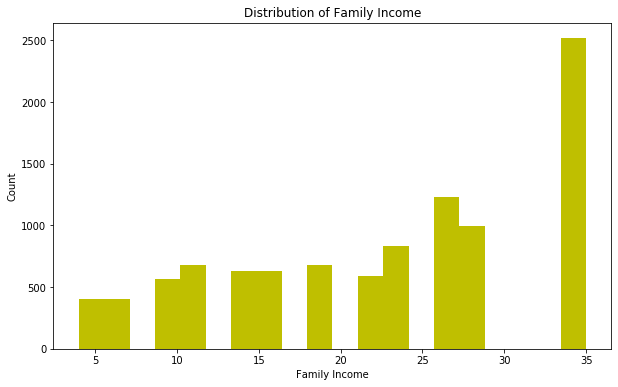

In [22]:
# Histogram of 'family_income'
plt.figure(figsize=(10, 6))
plt.hist(bd['fi'], bins=20,color='y')
plt.xlabel('Family Income')
plt.ylabel('Count')
plt.title('Distribution of Family Income')
plt.show()

In [38]:
bd.dtypes

REF_NO                               int64
children                             int64
year_last_moved                      int64
Average Credit Card Transaction    float64
Balance Transfer                   float64
Term Deposit                       float64
Life Insurance                     float64
Medical Insurance                  float64
Average A/C Balance                float64
Personal Loan                      float64
Investment in Mutual Fund          float64
Investment Tax Saving Bond         float64
Home Loan                          float64
Online Purchase Amount             float64
Investment in Commudity            float64
Investment in Equity               float64
Investment in Derivative           float64
Portfolio Balance                  float64
y                                    int32
ab_10                                uint8
ab_11                                uint8
ab_13                                uint8
ab_17                                uint8
ab_9       

* Now that the entire data is of numeric type, lets beging our modelling process after removing nas from the data.

In [39]:
bd.dropna(axis=0,inplace=True)
bd_train, bd_test = train_test_split(bd, test_size = 0.2,random_state=2)

In [40]:
x_train=bd_train.drop(["y","REF_NO"],1)
y_train=bd_train["y"]
x_test=bd_test.drop(["y","REF_NO"],1)
y_test=bd_test["y"]

In [41]:
logr=LogisticRegression(penalty="l2",class_weight="balanced",random_state=2)

In [42]:
logr.fit(x_train,y_train)

C:\Users\Ayushi Jadhav\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
# score model performance on the test data
roc_auc_score(y_test,logr.predict(x_test))

0.8993151632540122

* To arrive at the eventual 1,0 prediction , we need to find some way [some cutoff ] to convert predicted probabilites into two classes. Lets first get the probabilities out.

In [44]:
prob_score=pd.Series(list(zip(*logr.predict_proba(x_train)))[1])

* On these scores , we will consider many cutoffs between 0 to 1

In [45]:
cutoffs=np.linspace(0,1,100)

* For each of these cutoff , we are going to look at TP,FP,TN,FN values and caluclate KS. Then we'll chose the best cutoff as the one having highest KS.

In [46]:
KS_cut=[]
for cutoff in cutoffs:
    predicted=pd.Series([0]*len(y_train))
    predicted[prob_score>cutoff]=1
    df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])
    TP=len(df[(df["real"]==1) &(df["predicted"]==1) ])
    FP=len(df[(df["real"]==0) &(df["predicted"]==1) ])
    TN=len(df[(df["real"]==0) &(df["predicted"]==0) ])
    FN=len(df[(df["real"]==1) &(df["predicted"]==0) ])
    P=TP+FN
    N=TN+FP
    KS=(TP/P)-(FP/N)
    KS_cut.append(KS)

cutoff_data=pd.DataFrame(list(zip(cutoffs,KS_cut)),columns=["cutoff","KS"])

KS_cutoff=cutoff_data[cutoff_data["KS"]==cutoff_data["KS"].max()]["cutoff"]

* Now we'll see how this model with the cutoff determined here , performs on the test data.

In [47]:
# Performance on test data
prob_score_test=pd.Series(list(zip(*logr.predict_proba(x_test)))[1])

predicted_test=pd.Series([0]*len(y_test))
predicted_test[prob_score_test>float(KS_cutoff)]=1

df_test=pd.DataFrame(list(zip(y_test,predicted_test)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print('confusion matrix :\n \n ',k)
TN=k.iloc[0,0]
TP=k.iloc[1,1]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP

confusion matrix :
 
  predicted     0    1
real                
0          1646  161
1            26  198


In [48]:
# Accuracy of test
(TP+TN)/(P+N)

0.9079271294928607

In [49]:
# Sensitivity on test
TP/P

0.8839285714285714

In [50]:
#Specificity on test
TN/N

0.9109020475926951

* Next we see how cutoff determined by F_beta score performs on test data for beta values : 0.5,1,2

In [51]:
cutoffs=np.linspace(0.010,0.99,100)
def Fbeta_perf(beta,cutoffs,y_train,prob_score):
    FB_cut=[]
    for cutoff in cutoffs:
        predicted=pd.Series([0]*len(y_train))
        predicted[prob_score>cutoff]=1
        df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])

        TP=len(df[(df["real"]==1) &(df["predicted"]==1) ])
        FP=len(df[(df["real"]==0) &(df["predicted"]==1) ])
        FN=len(df[(df["real"]==1) &(df["predicted"]==0) ])
        P=TP+FN
        
        
        Precision=TP/(TP+FP)
        Recall=TP/P
        FB=(1+beta**2)*Precision*Recall/((beta**2)*Precision+Recall)
        FB_cut.append(FB)

    cutoff_data=pd.DataFrame(list(zip(cutoffs,FB_cut)),columns=["cutoff","FB"])

    FB_cutoff=cutoff_data[cutoff_data["FB"]==cutoff_data["FB"].max()]["cutoff"]

    prob_score_test=pd.Series(list(zip(*logr.predict_proba(x_test)))[1])

    predicted_test=pd.Series([0]*len(y_test))
    predicted_test[prob_score_test>float(FB_cutoff)]=1

    df_test=pd.DataFrame(list(zip(y_test,predicted_test)),columns=["real","predicted"])

    k=pd.crosstab(df_test['real'],df_test["predicted"])
#     print('confusion matrix :\n \n ',k)
    TN=k.iloc[0,0]
    TP=k.iloc[1,1]
    FP=k.iloc[0,1]
    FN=k.iloc[1,0]
    P=TP+FN
    N=TN+FP
    print('For beta :',beta)
    print('Accuracy is :',(TP+TN)/(P+N))
    print('Sensitivity is :',(TP/P))
    print('Specificity is :',(TN/N))
    print('\n \n \n')

In [52]:
Fbeta_perf(0.5,cutoffs,y_train,prob_score)
Fbeta_perf(1,cutoffs,y_train,prob_score)
Fbeta_perf(2,cutoffs,y_train,prob_score)

For beta : 0.5
Accuracy is : 0.9345150172328902
Sensitivity is : 0.48214285714285715
Specificity is : 0.9905921416712784

 
 

For beta : 1
Accuracy is : 0.9320531757754801
Sensitivity is : 0.7633928571428571
Specificity is : 0.9529607083563918

 
 

For beta : 2
Accuracy is : 0.9286065977351059
Sensitivity is : 0.8392857142857143
Specificity is : 0.9396790260099612

 
 



* You can see that low beta < 1 favors Specificity where as beta > 1 favors sensitivity